In [7]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
data_dir = "/home/lbenboudiaf/Bureau/ImagesClassification/dataset/GroceryStoreDataset/dataset/OneClasse"
model_name = "squeezenet"
num_classes = 3
batch_size = 8
num_epochs = 500 #Valeur Initiale par défaut comme dans le TP du Prof 
feature_extract = True
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    
    loss_val = []
    loss_train = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # récupéré le model et calculer sa fonction loss 
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase, Backward 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                loss_train.append(epoch_loss)
            else:
                loss_val.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_train, loss_val
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
#Definition du model Squeezenet.
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    else:
        print("Invalid model name")
        exit()

    return model_ft, input_size

# Initialisé le model pour ce dataset 
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
import os
# Augmentaion et normalisation de données pour le jeux d'apprentissage.  
# Normalisation des jeux de test et de validation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Generation de jeux d'apprentissage et de validation 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Creation des dataloaders pour jeux d'apprentissage et de validation. 
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Envoyer le model au GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observation des paramètres sont optimisé 
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Initializing Datasets and Dataloaders...
Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [10]:
import copy
import matplotlib.pyplot as plt
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist, train_loss, val_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

#ohist = []
shist = []

#ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]


Epoch 0/499
----------
train Loss: 1.1437 Acc: 0.3784
val Loss: 1.0860 Acc: 0.3412

Epoch 1/499
----------
train Loss: 1.0683 Acc: 0.3446
val Loss: 1.1886 Acc: 0.3581

Epoch 2/499
----------
train Loss: 1.0233 Acc: 0.4122
val Loss: 1.3885 Acc: 0.3345

Epoch 3/499
----------
train Loss: 1.0253 Acc: 0.4899
val Loss: 1.5262 Acc: 0.4459

Epoch 4/499
----------
train Loss: 0.9736 Acc: 0.5608
val Loss: 1.1882 Acc: 0.4493

Epoch 5/499
----------
train Loss: 0.9540 Acc: 0.5507
val Loss: 1.4972 Acc: 0.4324

Epoch 6/499
----------
train Loss: 0.9541 Acc: 0.5878
val Loss: 1.1718 Acc: 0.4628

Epoch 7/499
----------
train Loss: 0.9556 Acc: 0.5372
val Loss: 1.0753 Acc: 0.4628

Epoch 8/499
----------
train Loss: 0.9502 Acc: 0.5439
val Loss: 1.3814 Acc: 0.4020

Epoch 9/499
----------
train Loss: 0.9518 Acc: 0.5574
val Loss: 2.1865 Acc: 0.3953

Epoch 10/499
----------
train Loss: 0.9490 Acc: 0.5777
val Loss: 1.4438 Acc: 0.4358

Epoch 11/499
----------
train Loss: 0.9209 Acc: 0.5811
val Loss: 1.2643 Acc

val Loss: 10.0288 Acc: 0.4324

Epoch 97/499
----------
train Loss: 0.6810 Acc: 0.6453
val Loss: 7.3108 Acc: 0.4122

Epoch 98/499
----------
train Loss: 0.6801 Acc: 0.6588
val Loss: 7.5345 Acc: 0.4392

Epoch 99/499
----------
train Loss: 0.6598 Acc: 0.6588
val Loss: 9.7613 Acc: 0.4155

Epoch 100/499
----------
train Loss: 0.6622 Acc: 0.6453
val Loss: 3.5167 Acc: 0.4966

Epoch 101/499
----------
train Loss: 0.6786 Acc: 0.6689
val Loss: 6.5091 Acc: 0.4358

Epoch 102/499
----------
train Loss: 0.6482 Acc: 0.6689
val Loss: 9.7518 Acc: 0.4392

Epoch 103/499
----------
train Loss: 0.6425 Acc: 0.6655
val Loss: 6.4575 Acc: 0.4223

Epoch 104/499
----------
train Loss: 0.5976 Acc: 0.6689
val Loss: 7.5253 Acc: 0.4797

Epoch 105/499
----------
train Loss: 0.6063 Acc: 0.6622
val Loss: 7.0721 Acc: 0.4426

Epoch 106/499
----------
train Loss: 0.6661 Acc: 0.6318
val Loss: 13.6924 Acc: 0.4122

Epoch 107/499
----------
train Loss: 0.7673 Acc: 0.6554
val Loss: 9.2814 Acc: 0.4291

Epoch 108/499
----------


val Loss: 10.9658 Acc: 0.4426

Epoch 192/499
----------
train Loss: 0.5896 Acc: 0.6723
val Loss: 14.7294 Acc: 0.4358

Epoch 193/499
----------
train Loss: 0.6355 Acc: 0.7128
val Loss: 13.0728 Acc: 0.4696

Epoch 194/499
----------
train Loss: 0.5518 Acc: 0.6622
val Loss: 14.2926 Acc: 0.4459

Epoch 195/499
----------
train Loss: 0.5223 Acc: 0.7027
val Loss: 5.6593 Acc: 0.4459

Epoch 196/499
----------
train Loss: 0.5871 Acc: 0.7061
val Loss: 27.8112 Acc: 0.4324

Epoch 197/499
----------
train Loss: 0.5340 Acc: 0.6892
val Loss: 11.6892 Acc: 0.4324

Epoch 198/499
----------
train Loss: 0.5232 Acc: 0.7196
val Loss: 8.0115 Acc: 0.4899

Epoch 199/499
----------
train Loss: 0.5206 Acc: 0.7264
val Loss: 14.0123 Acc: 0.4426

Epoch 200/499
----------
train Loss: 0.5449 Acc: 0.6926
val Loss: 17.9633 Acc: 0.4358

Epoch 201/499
----------
train Loss: 0.5097 Acc: 0.7568
val Loss: 15.1576 Acc: 0.4662

Epoch 202/499
----------
train Loss: 0.5683 Acc: 0.7264
val Loss: 19.8889 Acc: 0.5034

Epoch 203/499


val Loss: 12.9972 Acc: 0.4764

Epoch 287/499
----------
train Loss: 0.4696 Acc: 0.7534
val Loss: 5.4476 Acc: 0.4662

Epoch 288/499
----------
train Loss: 0.4603 Acc: 0.7905
val Loss: 8.0689 Acc: 0.4527

Epoch 289/499
----------
train Loss: 0.4753 Acc: 0.7601
val Loss: 14.1888 Acc: 0.5000

Epoch 290/499
----------
train Loss: 0.4896 Acc: 0.7872
val Loss: 8.5871 Acc: 0.4223

Epoch 291/499
----------
train Loss: 0.4694 Acc: 0.7770
val Loss: 8.1660 Acc: 0.4054

Epoch 292/499
----------
train Loss: 0.5014 Acc: 0.7500
val Loss: 10.8362 Acc: 0.4459

Epoch 293/499
----------
train Loss: 0.4565 Acc: 0.7838
val Loss: 1.8342 Acc: 0.4392

Epoch 294/499
----------
train Loss: 0.4540 Acc: 0.8007
val Loss: 4.8412 Acc: 0.4628

Epoch 295/499
----------
train Loss: 0.4439 Acc: 0.7973
val Loss: 4.3604 Acc: 0.4561

Epoch 296/499
----------
train Loss: 0.4442 Acc: 0.7905
val Loss: 10.8423 Acc: 0.5034

Epoch 297/499
----------
train Loss: 0.4942 Acc: 0.8142
val Loss: 12.0813 Acc: 0.4527

Epoch 298/499
-----

val Loss: 2.3188 Acc: 0.4764

Epoch 382/499
----------
train Loss: 0.6212 Acc: 0.7196
val Loss: 3.3970 Acc: 0.4932

Epoch 383/499
----------
train Loss: 0.5191 Acc: 0.7736
val Loss: 6.0636 Acc: 0.5135

Epoch 384/499
----------
train Loss: 0.5177 Acc: 0.7838
val Loss: 1.1571 Acc: 0.5642

Epoch 385/499
----------
train Loss: 0.4260 Acc: 0.7534
val Loss: 2.2424 Acc: 0.4831

Epoch 386/499
----------
train Loss: 0.4078 Acc: 0.8615
val Loss: 2.1728 Acc: 0.4527

Epoch 387/499
----------
train Loss: 0.5034 Acc: 0.8243
val Loss: 2.8676 Acc: 0.4527

Epoch 388/499
----------
train Loss: 0.4986 Acc: 0.7703
val Loss: 1.3670 Acc: 0.4628

Epoch 389/499
----------
train Loss: 0.5045 Acc: 0.7872
val Loss: 1.7954 Acc: 0.5608

Epoch 390/499
----------
train Loss: 0.4980 Acc: 0.8007
val Loss: 1.4288 Acc: 0.5405

Epoch 391/499
----------
train Loss: 0.4059 Acc: 0.8007
val Loss: 1.5844 Acc: 0.5507

Epoch 392/499
----------
train Loss: 0.4342 Acc: 0.8345
val Loss: 1.3209 Acc: 0.4865

Epoch 393/499
----------

val Loss: 27.7831 Acc: 0.4831

Epoch 477/499
----------
train Loss: 0.4499 Acc: 0.8547
val Loss: 49.6572 Acc: 0.4426

Epoch 478/499
----------
train Loss: 0.4556 Acc: 0.8007
val Loss: 9.8611 Acc: 0.5034

Epoch 479/499
----------
train Loss: 0.5447 Acc: 0.8142
val Loss: 12.6020 Acc: 0.4831

Epoch 480/499
----------
train Loss: 0.4360 Acc: 0.8514
val Loss: 11.1592 Acc: 0.4932

Epoch 481/499
----------
train Loss: 0.4408 Acc: 0.8142
val Loss: 12.9587 Acc: 0.4662

Epoch 482/499
----------
train Loss: 0.4151 Acc: 0.8514
val Loss: 10.8826 Acc: 0.5000

Epoch 483/499
----------
train Loss: 0.4031 Acc: 0.8412
val Loss: 9.4798 Acc: 0.4730

Epoch 484/499
----------
train Loss: 0.4392 Acc: 0.8851
val Loss: 7.3847 Acc: 0.5304

Epoch 485/499
----------
train Loss: 0.4075 Acc: 0.8345
val Loss: 7.3659 Acc: 0.5169

Epoch 486/499
----------
train Loss: 0.3900 Acc: 0.8378
val Loss: 4.0520 Acc: 0.4426

Epoch 487/499
----------
train Loss: 0.4167 Acc: 0.8243
val Loss: 9.2740 Acc: 0.4797

Epoch 488/499
----

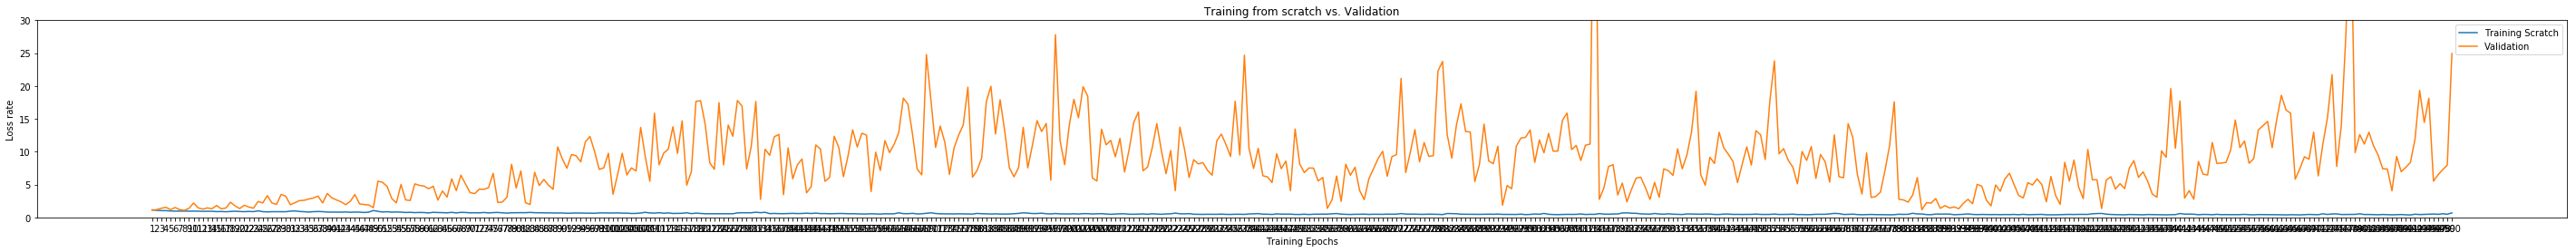

In [16]:
import matplotlib.pyplot as plt
plt.title("Training from scratch vs. Validation")
plt.xlabel("Training Epochs")
plt.ylabel("Loss rate")
plt.plot(range(1,num_epochs+1),train_loss,label="Training Scratch")
plt.plot(range(1,num_epochs+1),val_loss,label="Validation")
plt.ylim((0,30))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.rcParams["figure.figsize"] = (100,4)
plt.show()